# Семинар 2. Преобразование количественных данных

In [32]:
# импортируем библиотеки
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# установим размер и стиль Seaborn для последующих графиков
sns.set(rc = {'figure.figsize' : (8, 5)})

## 1. Обсуждение методов 

### Подготовка данных

In [118]:
# возьмем признак LSTAT (процент населения с низким социальным статусом)
# и целевую переменную MEDV (медианная стоимость жилья)
boston = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')[['age','lstat', 'medv']]

In [119]:
# посмотрим на основные статистические показатели
stats = boston.describe()

#Добавим асимметрию
stats.loc['skew'] = boston.skew()
# и эксцесс
stats.loc['kurtosis'] =  boston.kurtosis()
stats

,age,lstat,medv
count,506.000000,506.000000,506.000000
mean,68.574901,12.653063,22.532806
std,28.148861,7.141062,9.197104
min,2.900000,1.730000,5.000000
25%,45.025000,6.950000,17.025000
50%,77.500000,11.360000,21.200000
75%,94.075000,16.955000,25.000000
max,100.000000,37.970000,50.000000
skew,-0.598963,0.906460,1.108098
kurtosis,-0.967716,0.493240,1.495197


<Axes: ylabel='Density'>

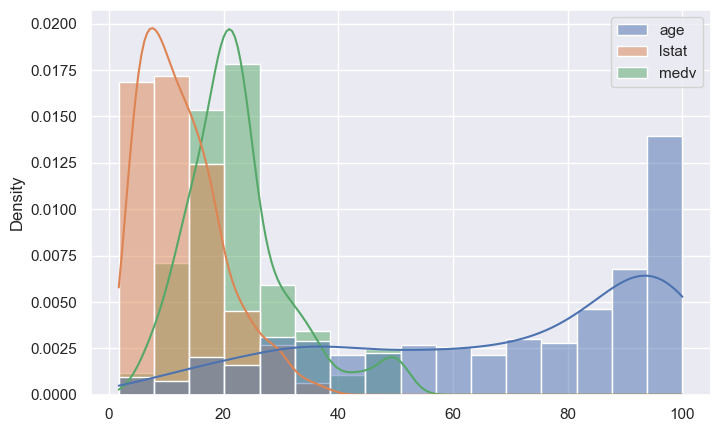

In [120]:
# посмотрим на данные с помощью гистограммы
sns.histplot(boston, kde=True,stat = 'density')
# boston.hist(bins = 15, figsize = (10, 5));

Посмотрим, как сильно отличается наше распределение от нормального.
Для этого построим **Q-Q диаграму** - график сопоставляющий квантилям теоретического распределения (нормального в нашем случае) - квантили наблюдаемого распределения.

Нулевой квантиль соответствует медиане ($q_{0.5}$), $1$ - верхнему квартилю ($q_{0.75}$), $-1$ - нижнему кварилю ($q_{0.25}$)

Подробнее о Q-Q диаграмме читайте здесь: [Q-Q Plots. От чайника до профессионала за один гайд // Хабр, 2021](https://habr.com/ru/articles/578754/)

Чем сильнее отклоняется график от прямой, тем сильнее отличие от теоретического распределения.

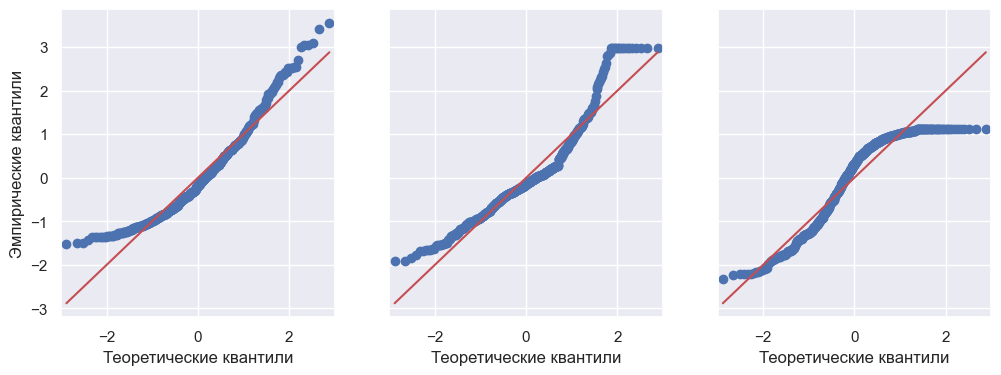

In [128]:

fig, axs = plt.subplots(
    ncols=3, # число колонок
    sharey=True, # Общая ось Y
    figsize = (12,4)
)

sm.qqplot(boston['lstat'], dist=st.norm, line='s', fit=True, ax=axs[0])
sm.qqplot(boston['medv'], dist=st.norm, line='s', fit=True, ax=axs[1])
sm.qqplot(boston['age'], dist=st.norm, line='s', fit=True, ax=axs[2])
for ax in axs:
    ax.set_xlabel("Теоретические квантили")
    ax.set_ylabel("")
axs[0].set_ylabel("Эмпирические квантили")

plt.show();


 Видим, что распределеления обеих наблюдаемых величин  отличаются от нормального

Однако, именно нормальное распределение хорошо изучено. Большинство статистических методов замечательно работает с нормальными данными. Более того, для многие модели ML предполагают нормально распределенные данные.


**Наша цель:** преобразовать данные так, чтобы распределение было как можно ближе к нормальному.

**Путь решения:** Выполнить преобразование данных так, чтобы выровнять Q-Q график.

### Виды преобразований
При обработке  данных применяются два типа преобразований:
- *Масштабирование* - линейное преобразование - не меняет структуры распределения, но позволяет привести параметры распределения к эталонным, например $N(\mu,\sigma) \to N(0,1)$
- *Нелинейные преобразования* - меняют форму распределения и используются для приближения эмпирического распределения к требуемому теоретическому.

Рассмотрим пример:
- В качестве масштабирования возьмем преобразование стандартизации 
$ X' = \frac{X-\bar(X)}{s_X}$
где $\bar{X}$ - выборочная средняя, $s_X$ - выборочное среднее квадратическое отклонение.

- В качестве нелинейного преобразования - преобразование Бокса-Кокса.


In [61]:
# Загрузим функции преобразований:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer 

std_scaler = StandardScaler()
bc_transformer = PowerTransformer(method = 'box-cox', standardize=True)

# Выполним линейное преобразование
X = boston[['lstat']]
X['std-scale'] = std_scaler.fit_transform(X[['lstat']])
X['box-cox-transform'] = bc_transformer.fit_transform(X[['lstat']])


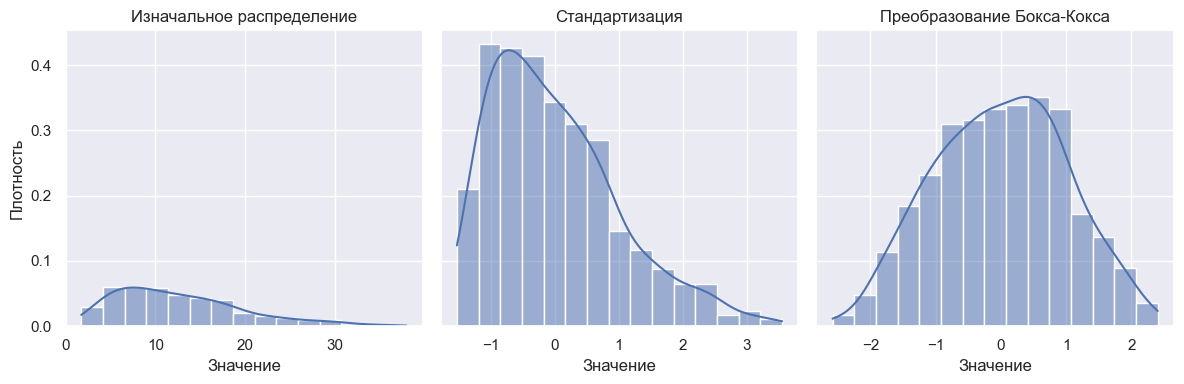

In [78]:
# создадим сетку подграфиков 1 x 3
fig, axs = plt.subplots(
    ncols=3, # число колонок
    sharey=True, # Общая ось Y
    figsize = (12,4)
)

# на первом графике разместим изначальное распределение
sns.histplot(data = X, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение', xlabel = 'Значение', ylabel = 'Плотность')
# на втором - данные после стандартизации
sns.histplot(data = X, x = 'std-scale', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Стандартизация',xlabel = 'Значение')
# и на третьем графике покажем преобразование Бокса-Кокса
sns.histplot(data = X, x = 'box-cox-transform', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[2]).set(title = 'Преобразование Бокса-Кокса',xlabel = 'Значение')
plt.tight_layout()
plt.show()

- В первом случае форма распределения сохранилась, изменился только масштаб. 
- Во втором случае, изменилась сама структура распределения, то есть соотношение расстояний между точками.

#### Добавление выбросов

Выбросы очень сильно влияют на качество данных. Для того чтобы посмотреть, как рассматриемые нами инструменты справляются с выбросами, добавим несколько сильно отличающихся от общей массы наблюдений.

In [134]:
# создадим два отличающихся наблюдения
outliers = pd.DataFrame({
    'lstat': [45, 50],
    'medv': [70, 72],
    'age': [1, 1],
    })

# добавим их в исходный датафрейм
boston_outlier = pd.concat([boston, outliers], ignore_index = True)

# посмотрим на размерность нового датафрейма
boston_outlier.shape

(508, 3)

In [135]:
boston_outlier

,age,lstat,medv
0,65.2,4.98,24.0
1,78.9,9.14,21.6
2,61.1,4.03,34.7
3,45.8,2.94,33.4
4,54.2,5.33,36.2
...,...,...,...
503,91.0,5.64,23.9
504,89.3,6.48,22.0
505,80.8,7.88,11.9
506,1.0,45.00,70.0


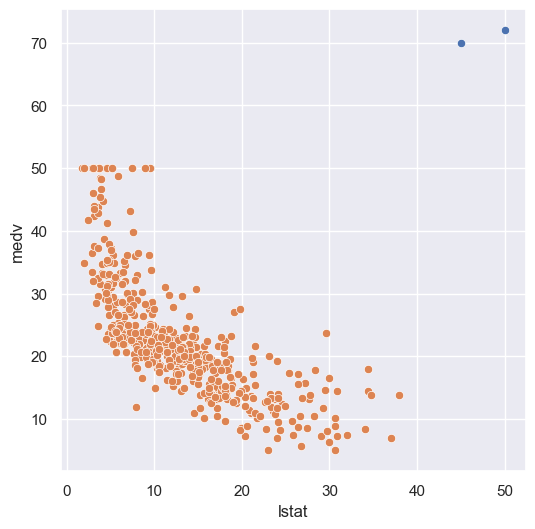

In [136]:
# убедимся, что наблюдения добавились
fig, axs = plt.subplots(1, 1, figsize = (6,6))

sns.scatterplot(data = boston_outlier, x = 'lstat', y = 'medv', ax = axs)
sns.scatterplot(data = boston, x = 'lstat', y = 'medv', ax = axs)
plt.plot();
# видим синие выбросы


### Линейные преобразования

#### Стандартизация

Если данные удовлетворяют нормальному или близкому к нормальному распределению, то имеет смысл прибегнуть к стандартизации: то есть приведению к нулевому среднему значению и единичному среднему квадратичному отклонению.

Это легко сделать по формуле 
$$ 
X' = \frac{X-\bar{X}}{s_X}
$$

Или воспользоваться классом `StandardScaler` из `sklearn.preprocessing`.

**ЗАДАНИЕ** - Реализуйте стандартизацйию данных из `boston_outlier` вручную и с помощью `StandardScaler`. 

- Убедитесь в том, что данные одинаковы
- Сохраните данные в `boston_outlier_scaled`
- Постройте графики и убедитесь, что выбросы сохранились. А что произошло с данными?
- Выполните обратное преобразование, сохранив результат в `boston_outlier_inverse`. (Вернуть исходный масштаб можно как по формуле, так и с помощью метода `.inverse_transform()` класса `StandardScaler`).
- Будут ли данные одинаковы?

In [137]:
# Ваш код:

**Замечание:**
Если при разработке моделей ML мы отмасштабируем все данные (обучающую и тестовую выборки), то получим утечку информации о тестовой выборке.

Поэтому, алгоритм масштабирования, как впрочем и других преобразований следующий:
1. Рассчитать параметры преобразования (среднее и СКО) для обучающей выборки
2. Отмасштабировать обучающую выборку
3. Обучить  модель
4. **Использовать ранее рассчитанные параметры** (среднее и СКО) для масштабирования тестовых данных
5. Сделать прогноз на отмасштабированных тестовых данных.
6. Оценить качество модели.

#### Приведение к диапазону 

Приведение к диапазону  используется, если требуется работать с данными из некоторого отрезка. Например, теоремы об апроксимации (функций нейросетями) доказаны для входных данных из отрезка $[0;1]$.

Приведение данных к отрезку $[0;1]$ можно выполнить по формуле:
$$
    x' = \frac{x-x_{\min}}{x_{\max}-x_{\min}}
$$

Это преобразование реализуется с помощью класса from  import `MinMaxScaler` из `sklearn.preprocessing`.


Проблема преобразования приведения к диапазону - чувствительность к выбросам. Их наличие существенно снижает вариацию данных.

In [138]:
# импортируем класс MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# создаем объект этого класса,
# в параметре feature_range оставим диапазон по умолчанию
minmax = MinMaxScaler(feature_range = (0, 1))

# применим метод .fit() и
minmax.fit(boston)

# найдем минимальные и максимальные значения
minmax.data_min_, minmax.data_max_

(array([2.9 , 1.73, 5.  ]), array([100.  ,  37.97,  50.  ]))

In [139]:
# приведем данные без выбросов (достаточно метода .transform())
boston_scaled = minmax.transform(boston)

# и с выбросами к заданному диапазону
boston_outlier_scaled = minmax.fit_transform(boston_outlier)

# преобразуем результаты в датафрейм
boston_scaled = pd.DataFrame(boston_scaled, columns = boston.columns)
boston_outlier_scaled = pd.DataFrame(boston_outlier_scaled, columns = boston.columns)

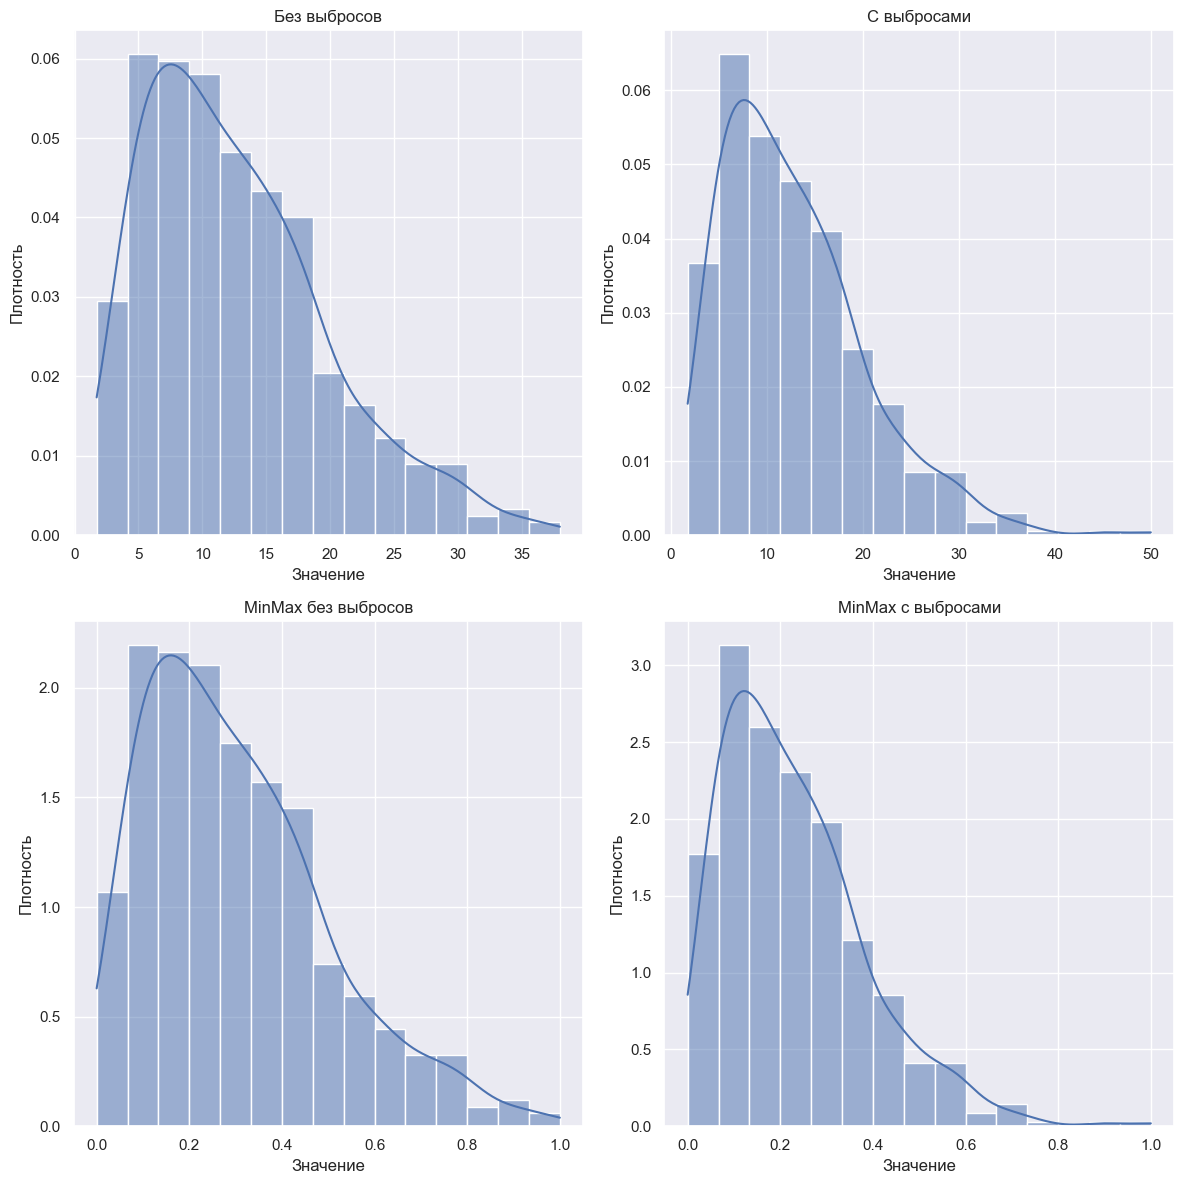

In [140]:
# построим точечные диаграммы
fig, axs = plt.subplots(
    nrows=2, # число строк
    ncols=2, # число колонок
    figsize = (12,12),
)
sns.histplot(data = boston, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0,0]).set(title = 'Без выбросов',xlabel = 'Значение',ylabel = 'Плотность')
sns.histplot(data = boston_outlier, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0,1]).set(title = 'C выбросами',xlabel = 'Значение',ylabel = 'Плотность')
sns.histplot(data = boston_scaled, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1,0]).set(title = 'MinMax без выбросов',xlabel = 'Значение',ylabel = 'Плотность')
sns.histplot(data = boston_outlier_scaled, x = 'lstat', 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1,1]).set(title = 'MinMax с выбросами',xlabel = 'Значение',ylabel = 'Плотность')
plt.tight_layout()
plt.show();


#### Робастое масштабирование

Выполним масштабирование относительно нижнего и верхнего квартилей
$$
x' = \frac{x-Q_{I}}{Q_{III}-Q_{I}}
$$

Такое преобразование более устойчиво к выбросам.
Может быть реализовано с помощью `RobustScaler` из `sklearn.preprocessing`

**Задание:** Поэкспериментируйте с робастым масштабированием сами.

In [143]:
# Ваш код:

### Нелинейные преобразования

#### Логарифмическое преобразование
$$
X' = \ln X
$$
* В результате преобразования: 
    - расстояние между небольшими значениями увеличивается;
    - расстояние между большими значениями - уменьшается.
* Применяется с целью компенсации **положительной асимметрии** распределения. Оно делает скошенное вправо распределение более симметричным и, следовательно, более близким к нормальному. 
* Логарифмическое преобразование легко интерпретировать. 
Уменьшим $X$ на 15% и вычислим его логарифм. $\ln(0.85\cdot X) = \ln(0.85)+ \ln X = -0.163 + X'$.
Таким образом, снижение на $0.163$ преобразованного значения свидетельствует о снижении на 15% в исходных данных вне зависимости от их масштаба.

* К сожалению, преобразование возможно только для положительных исходных значений.



In [144]:
X = boston[['lstat']]
X['log_trans'] = np.log(X['lstat'])

/tmp/ipykernel_212028/4165858177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_trans'] = np.log(X['lstat'])


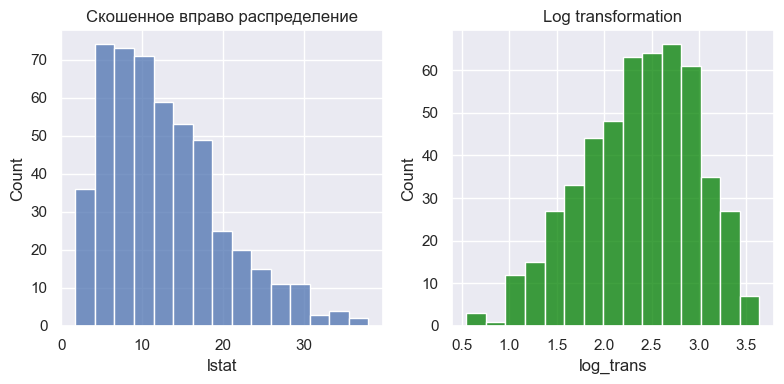

In [145]:
fig, axs = plt.subplots(
    nrows = 1, 
    ncols = 2, 
    figsize = (8,4)
)


sns.histplot(x = X['lstat'], bins = 15, ax = axs[0]).set(title='Скошенное вправо распределение')

sns.histplot(x = X['log_trans'],
             bins = 15, color = 'green',
            ax = axs[1]).set(title = 'Log transformation')

plt.tight_layout()
plt.show();

In [146]:
# рассчитаем ассиметрию до и после преобразования
X.skew()


lstat        0.906460
log_trans   -0.320232
dtype: float64

In [147]:
# рассчитаем коэффициент эксцесса до и после преобразования
X.kurtosis()

lstat        0.493240
log_trans   -0.431477
dtype: float64

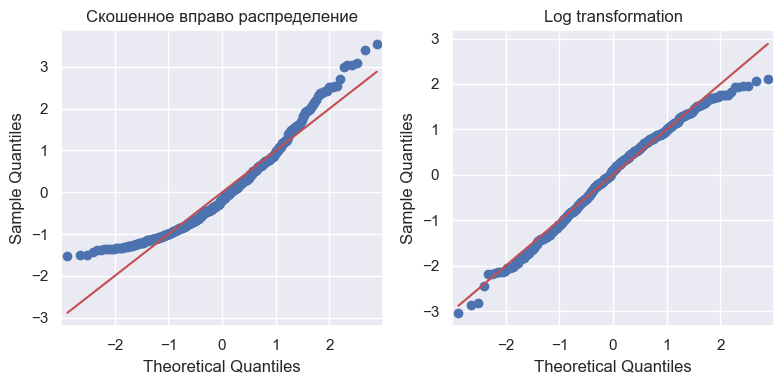

In [148]:
# построим Q-Q диаграмы нормальной вероятности
from scipy.stats import probplot

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sm.qqplot(X['lstat'], dist=st.norm, line='s', fit=True, ax=axs[0])
axs[0].set_title('Скошенное вправо распределение')

sm.qqplot(X['log_trans'], dist=st.norm, line='s', fit=True, ax=axs[1])
axs[1].set_title('Log transformation')

plt.tight_layout()
plt.show();

# и визуально оценим, приблизилось ли распределение к нормальному.

**Задание:** Сделайте то же самое над датасетом с выбросами.

Как влияет наличие выборосов на качество выравнивания асимметрии?


In [149]:
# Ваш код:

Логарифмическое преобразование способно корректировать положительную асимметрию. 
Однако, для правой асимметрии оно совершенно не применимо.

Рассмотрим, например, возраст продаваемых квартир (поле age)

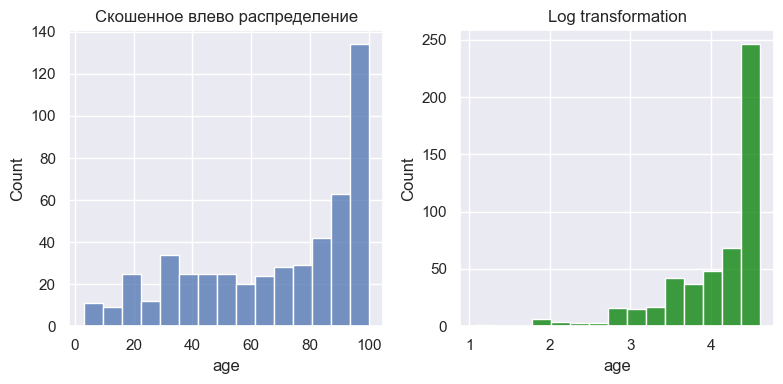

In [154]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.histplot(x = boston['age'], bins = 15, ax = axs[0])
axs[0].set_title('Скошенное влево распределение')

sns.histplot(x = np.log(boston['age']),
             bins = 15, color = 'green',
            ax = axs[1])
axs[1].set_title('Log transformation')

plt.tight_layout()
plt.show()

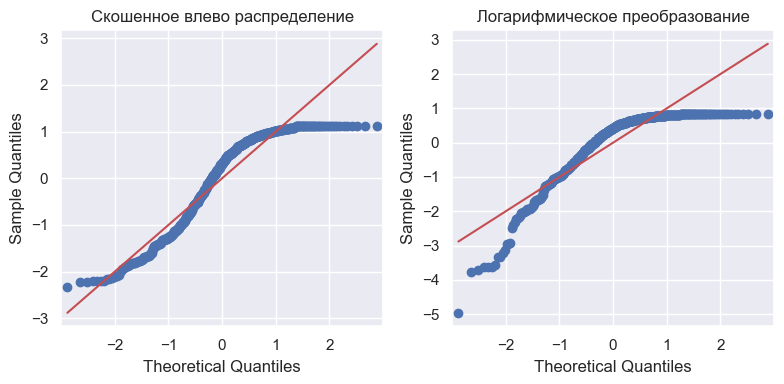

In [158]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sm.qqplot(boston['age'], dist=st.norm, line='s', fit=True, ax=axs[0])
axs[0].set_title('Скошенное влево распределение')

sm.qqplot(np.log(boston['age']), dist=st.norm, line='s', fit=True, ax=axs[1])
axs[1].set_title('Логарифмическое преобразование')

plt.tight_layout()
plt.show()

#### Логарифмическое преобразование над отрицательными числами:

Если в данных встречаются отрицательные числа или нуль, то логарифмическое преобразование неприменимо.

В этом случае можно воспользоваться  преобразованием *обратного гиперболического синуса* (inverse hyperbolic sine)
$$
    x' = \mathrm{\mathop{IHS}}(x) = \ln( x+ \sqrt{x^2+1})
$$
Заметим, что это преобразование обратимо:
$$
\begin{gathered}
x' = \ln( x+ \sqrt{x^2+1})\\
(e^{x'} - x)^2 = x^2+1\\
e^{2x'}- 2e^{x'}x = 1\\
x = \frac{e^{2x'}- 1}{2e^{x'}}\\
x = \frac{1}{2} \left(e^{x'}-e^{-x'}\right)
\end{gathered}
$$

**Задание:** 
- Изобразите график функции $\mathrm{\mathop{IHS}}(x)$. Как изменяет функция расстояние между элементами в отрицательной и положительной областях?
- Попробуйте применить IHS преобразование после преобразования нормализации для полей `lstat` и `age`. 
- Есть ли качественные отличия от преобразования логарифмирования?

In [159]:
# Ваш код:

#### Преобразование Бокса-Кокса
Преобразование Бокса-Кокса (Box-Cox) является параметрическим обобщением преобразования логарифмирования:
$$
y^{(\lambda)} = \begin{cases}
\frac{y^\lambda-1}{\lambda}, & \text{ если $\lambda \neq 0$},\\ 
\ln y, & \text{ если $\lambda = 0$}.\\ 
\end{cases}
$$

* Параметр выбирается методом максимального правдоподобия (maximum likelihood method). 
* Преобразование Бокса-Кокса применимо только для положительных данных.
* При использовании преобразования Бокса-Кокса нужно сохранить параметр $\lambda$, чтобы применять его к тестовой выборке и в дальнейшем в модели. 

In [160]:
pt = PowerTransformer(method = 'box-cox')

# найдем оптимальный параметр лямбда
pt.fit(boston[['lstat']])

pt.lambdas_

array([0.22776736])

In [161]:
# преобразуем данные
bc_pt = pt.transform(boston[['lstat']])

# метод .transform() возвращает двумерный массив
bc_pt.shape

(506, 1)

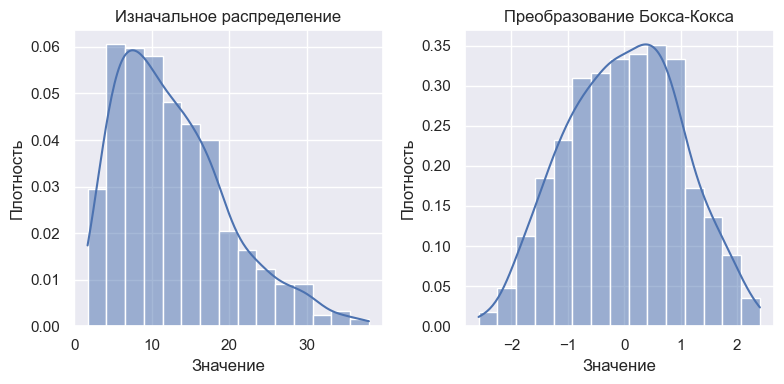

In [166]:
# сравним изначальное распределение и распределение после преобразования Бокса-Кокса
fig, axs = plt.subplots(
    nrows = 1, 
    ncols = 2, 
    figsize = (8,4)
)

sns.histplot(x = boston['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение',xlabel = 'Значение',ylabel = 'Плотность')

# так как на выходе метод .transform() выдает двумерный массив,
# его необходимо преобразовать в одномерный
sns.histplot(x = bc_pt.flatten(), 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Преобразование Бокса-Кокса',xlabel = 'Значение',ylabel = 'Плотность')
plt.tight_layout()
plt.show()

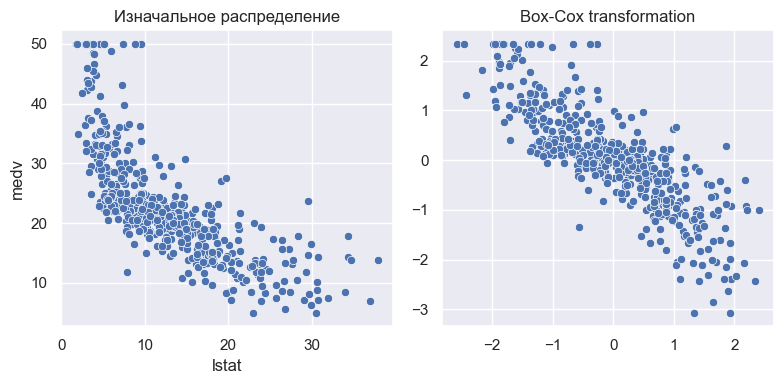

In [169]:
# оценим изменение взаимосвязи после преобразования Бокса-Кокса
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

sns.scatterplot(x = boston['lstat'], y = boston['medv'], ax = axs[0])
axs[0].set_title('Изначальное распределение')

# можно использовать функцию power_transform(),
# она действует аналогично классу, но без estimator
sns.scatterplot(x = pt.fit_transform(boston[['lstat']]).flatten(),
                y = pt.fit_transform(boston[['medv']]).flatten(),
                ax = axs[1])
axs[1].set_title('Box-Cox transformation')

plt.tight_layout()

plt.show()

Как видим, появилась зависимость, близкая к линейной

#### Преобразование Йео-Джонсона (Yeo-Johnson transformation)
$$
y^{(\lambda)} = \begin{cases}
\frac{(1+y)^\lambda-1}{\lambda}, & \text{ если $\lambda \neq 0$ и $y \geqslant 0$},\\ 
\ln (1+y), & \text{ если $\lambda = 0$ и $y \geqslant 0$},\\ 
- \frac{(1-y)^{2-\lambda}-1}{2-\lambda}, & \text{ если $\lambda \neq 2$ и $y < 0$},\\ 
-\ln (1-y), & \text{ если $\lambda = 2$ и $y <0 $}.
\end{cases}
$$

Обобщение преобразования Бокса-Кокса на нулевые и отрицательные значения.

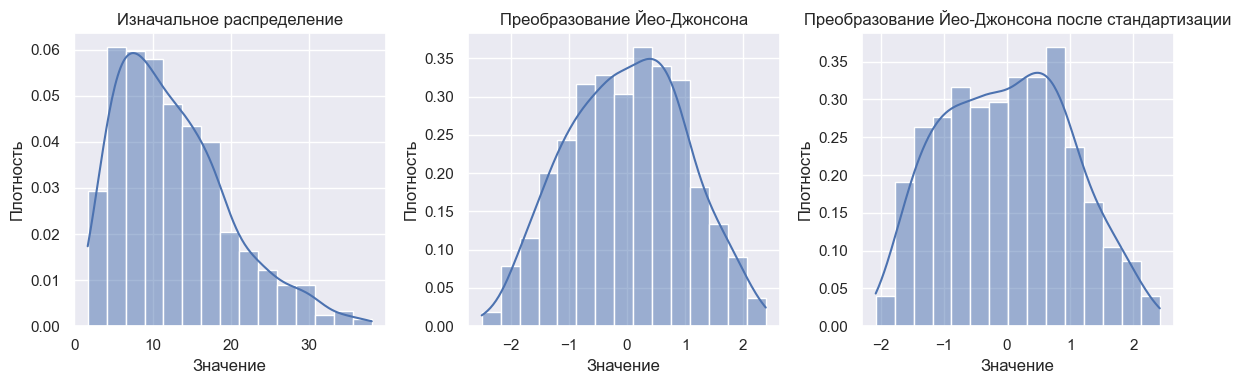

In [176]:
# попробуем преобразование Йео-Джонсона
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

sns.histplot(x = boston['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение',xlabel = 'Значение',ylabel = 'Плотность')
axs[0].set_title('Изначальное распределение')

scaler = StandardScaler()
yj = PowerTransformer(method='yeo-johnson')
lstat_scale = scaler.fit_transform(boston[['lstat']])
lstat_yj = yj.fit_transform(boston[['lstat']])
lstat_scale_yj = yj.fit_transform(lstat_scale)


sns.histplot(x = lstat_yj.flatten(), 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Преобразование Йео-Джонсона',xlabel = 'Значение',ylabel = 'Плотность')

sns.histplot(x = lstat_scale_yj.flatten(), 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[2]).set(title = 'Преобразование Йео-Джонсона после стандартизации',xlabel = 'Значение',ylabel = 'Плотность')
plt.tight_layout()
plt.show()

**Задание:** Вычислите коэффициенты асимметрии и эксцесса всех трех случаев и постройте QQ-диаграммы

#### Квантильное преобразование

При квантильном преобразовании (quantile transformation) исходным данным присваивается квантильный ранг в целевом (равномерном или нормальном) распределении. Этот ранг и есть новая преобразованная оценка.

Особенность такого преобразования заключается в том, что новое распределение никак не связано с исходным. Рассмотрим пример преобразования данных с выбросами.



In [178]:
from sklearn.preprocessing import QuantileTransformer

# приведем переменные с выбросами (!) к нормальному распределению
# с помощью квантиль-функции
qt = QuantileTransformer(n_quantiles = len(boston_outlier),
                         output_distribution = 'normal',
                         random_state = 42)

# для каждого из столбцов вычислим квантили нормального распределения,
# соответствующие заданному выше количеству квантилей (n_quantiles)
# и преобразуем (map) данные к нормальному распределению
boston_qt = pd.DataFrame(qt.fit_transform(boston_outlier),
                         columns = boston_outlier.columns)

# посмотрим на значения, на основе которых будут рассчитаны квантили
qt.quantiles_[-5:]

array([[100.  ,  34.77,  50.  ],
       [100.  ,  36.98,  50.  ],
       [100.  ,  37.97,  50.  ],
       [100.  ,  45.  ,  70.  ],
       [100.  ,  50.  ,  72.  ]])

In [179]:
# посмотрим на соответствующие им квантили нормального распределения
qt.references_[-5:]

array([0.99211045, 0.99408284, 0.99605523, 0.99802761, 1.        ])

In [188]:
# рассчитаем предпоследнее значение с помощью библиотеки scipy

st.norm.ppf(0.99802761, loc = 0, scale = 1)

np.float64(2.8825440308212347)

In [189]:
# сравним с преобразованными значениями
boston_qt['lstat'].sort_values()[-5:]

373    2.413985
414    2.517047
374    2.656761
506    2.882545
507    5.199338
Name: lstat, dtype: float64

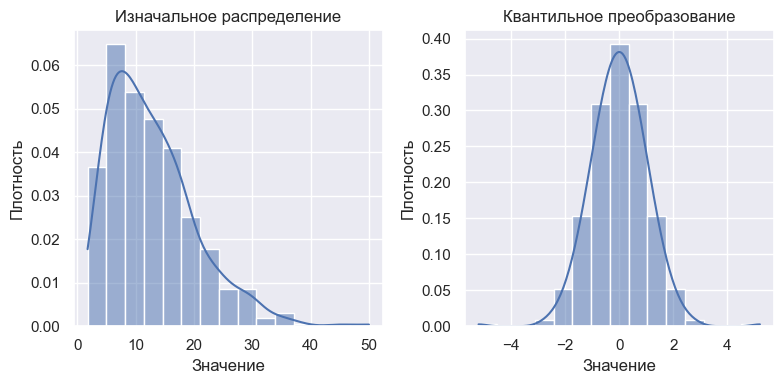

In [185]:
# выведем результат
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))


sns.histplot(x = boston_outlier['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[0]).set(title = 'Изначальное распределение',xlabel = 'Значение',ylabel = 'Плотность')

sns.histplot(x = boston_qt['lstat'], 
             bins = 15,
             kde=True,
             stat = 'density',
             ax = axs[1]).set(title = 'Квантильное преобразование',xlabel = 'Значение',ylabel = 'Плотность')

plt.tight_layout()
plt.show()

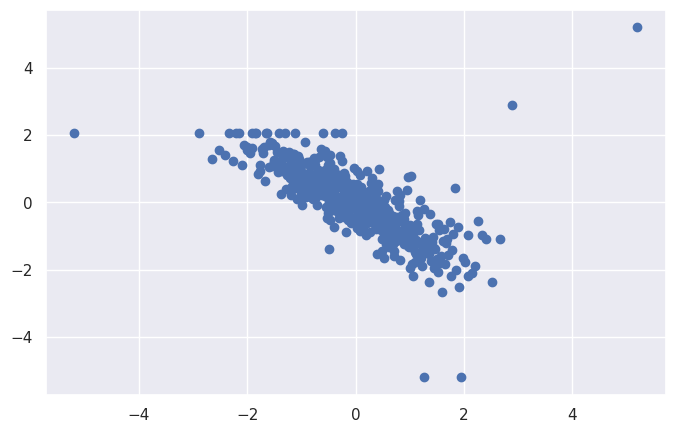

In [ ]:
# посмотрим, выправилась ли взаимосвязь
plt.scatter(boston_qt.LSTAT, boston_qt.MEDV);

Исходя из преобразованных значений (посмотрите на значение с индексом 507) и точечной диаграммы мы видим, что эффект выбросов сохранился.

## Задание

В качестве датасета предлагаю использовать [Макроэкономическую статистику России с 2005 по 2021](https://www.kaggle.com/datasets/zavidnikitamahbub/russian-economy-macroeconomic-data-2005-2021).
Локальная копия в репозитории ([Datasets/Russian_Macroeconomic_dataset.csv](https://gitflic.ru/project/chupdiv/asa_course/blob/raw?file=Datasets%2FRussian_Macroeconomic_dataset.csv))

Поля датасета:
- `Date` - Квартальные даты с 1 января 2005 года по 1 октября 2021 года
- `GDP` - Ежеквартальный номинальный ВВП в ценах 2016 года, без учёта сезонного фактора (млрд рублей)
- `GDPgr` - Номинальный темп роста ВВП (поквартально, %)
- `M0` - Базовые деньги (млрд руб.) - наличные деньги в национальной валюте в обращении вне банковской системы + наличность в кассах Банка России и кредитных учреждений.
- `M0gr` - Темп роста M0 (ежеквартально, %)
- `BM` - Показатель денежной массы М2 (млрд руб.) - денежные средства, доступные без продажи активов и валютных операций - наличные деньги + безналичные деньги на вкладах до востребования, расчетных и текущих счетах резидентов РФ в рублях + плюс срочные вклады в рублях резидентов России
- `BMgr`: Темпы роста М2 (ежеквартально, %)
- `Interest`: 90-дневная межбанковская ставка (годовых, %)
- `USDRUB` - Обменный курс USD/RUB (RUB)
- `EURRUB` - Курс обмена EUR/RUB (RUB)
- `Unemployment` -  Уровень безработицы (%)
- `PPI` -  Индекс цен производителей внутри страны (индекс: 2015 = 100)
- `PPIgr` - Темпы роста индекса цен производителей (ежеквартально, %)
- `OIL` -  Спотовые цены на нефть марки Brent за баррель (USD)
- `OILgr` -  Темпы роста цен на нефть марки Brent (поквартально, %)
- `WAGE` - Среднемесячная номинальная заработная плата (руб.)
- `WAGEgr` - Изменение номинальной ставки заработной платы (ежеквартально, %)
- `CPI`: Изменение индекса потребительских цен (ИПЦ) в процентах (конец квартала по сравнению с концом предыдущего квартала)
- `Inflation` - Процентное изменение ИПЦ, рассчитанное как относительный ИПЦ - 100 (ежеквартально, %)

### 1. Загрузка и очистка данных
1. Загрузите набор данных
2. Определите наличие выбросов и пропусков. Скорректируйте данные.

In [219]:
df = pd.read_csv(
    'https://gitflic.ru/project/chupdiv/asa_course/blob/raw?file=Datasets%2FRussian_Macroeconomic_dataset.csv', 
    sep=',', 
    index_col=0
)

### 2. Первичный анализ данных:

1. Вычислите статистические характеристики числовых данных.
2. Визуализируйте распределение выбранных переменных с помощью гистограмм и Q-Q диаграм. 
3. Сравните распределение с нормальным. Для этого на одном полотне изобразите функцию плотности нормального распределения, эмпирическую функцию плотности и гистограмму.  Можете проверить нормальность распределения с использованием теста Шапиро-Уилка.

### 3. Преобразование данных параметирческими методами
1. Для полей, распределения которых отличаются от нормальных подберите метод трансформации наилучшим способом приближающий данные (логарифмирование, обратный гиперболическй синус, Бокса-Кокса, Йео-Джонсона). Для параметрических методов укажите оптимальный параметр. 
Приветсвуется осознанное составление композиций из симметричного и асимметричного преобразований, например стандартизация после логарифмирования.

2. Графически или с помощью теста Шапиро-Уилка проверьте удалось ли преобразовать данные к нормальному распределению.



### 4. Преобразование данных непараметирческими методами

1. Примените квантильное преобразование к той же переменной с целью приведения её распределения к нормальному виду.

2. Визуализируйте результаты преобразования (гистограммы и Q-Q графики).

3. Проверьте нормальность распределения данных после квантильного преобразования.

4. Сравните качество квантильного преобразования с лучшим параметрическим преобразованием. 

5. Целесообразно ли использовать композицию линейного и квантильного преобразований?



### 5. ML, который мы любим:
Исследуйте влияние выбранного метода преобразования на качество решения какой-либо задачи машинного обучения (регрессии или классификации). Например, прогнозирование ИПЦ

Для этого:

1. Сформулируйте задачу.

2. Разделите данные на обучающую и тестовую выборки.

3. Обучите модель одного и того же типа на исходных данных и на данных, преобразованных выбранным методом.

4. Выберите подходящую метрику и оцените качество модели.

5. Сделайте вывод о целесообразности применения того или иного метода для вашей задачи.